In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics

In [35]:
# Read in the data & setup
Data = pd.read_csv("https://raw.githubusercontent.com/anton-selitskiy/RIT_ML/main/2024_spring/Homeworks/HW2/HW2/houses.csv")
onee = OneHotEncoder()
imp = SimpleImputer()
sc = StandardScaler()

In [36]:
# Fill in missing data for total bedrooms
Data['total_bedrooms'] = imp.fit_transform(Data[['total_bedrooms']])

# Make sure the counts line up
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [37]:
# Create features X and targets y
y = Data['median_house_value']
X = Data.drop(columns=['median_house_value'])

# Split dataset into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [38]:
# Create transformation where ocean_proximity is one encoded
transformation = ColumnTransformer(transformers=[('one-hot', onee, ["ocean_proximity"])], remainder='passthrough')
transformation.fit(X_train)
transformation.get_feature_names_out()
data_transformed = pd.DataFrame(transformation.transform(X_train), columns=transformation.get_feature_names_out())
data_transformed.head()

,one-hot__ocean_proximity_<1H OCEAN,one-hot__ocean_proximity_INLAND,one-hot__ocean_proximity_ISLAND,one-hot__ocean_proximity_NEAR BAY,one-hot__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age,remainder__total_rooms,remainder__total_bedrooms,remainder__population,remainder__households,remainder__median_income
0,0.0,0.0,0.0,1.0,0.0,-122.08,37.97,9.0,2643.0,439.0,1105.0,467.0,6.6579
1,0.0,0.0,0.0,1.0,0.0,-122.39,37.80,25.0,4561.0,1474.0,1525.0,1169.0,4.5581
2,0.0,0.0,0.0,0.0,1.0,-124.08,40.86,18.0,1287.0,484.0,805.0,502.0,1.1157
3,1.0,0.0,0.0,0.0,0.0,-117.89,33.74,32.0,660.0,145.0,959.0,113.0,3.7500
4,1.0,0.0,0.0,0.0,0.0,-118.30,33.90,19.0,2421.0,689.0,1726.0,660.0,3.2870


In [39]:
# Find the best value of K
best_score = 0
best_k = 0
for k in range (1, 41):
  X_train_transformed = transformation.fit_transform(X_train)
  neigh = KNeighborsRegressor(n_neighbors=k, metric='manhattan')
  neigh.fit(X_train_transformed, y_train)

  X_test_transformed = transformation.transform(X_test)
  y_pred = neigh.predict(X_test_transformed)

  score = metrics.explained_variance_score(y_test, y_pred)
  if (score > best_score):
    best_score = score
    best_k = k


#train our model based on the best value of K we found
X_train_transformed = transformation.fit_transform(X_train)
neigh = KNeighborsRegressor(n_neighbors=best_k, metric='manhattan')
neigh.fit(X_train_transformed, y_train)

X_test_transformed = transformation.transform(X_test)
y_pred = neigh.predict(X_test_transformed)

print("Non-scaled accuracy")
print("Best value of K: ", best_k)
print("Accuracy: ", best_score)

Non-scaled accuracy
Best value of K:  20
Accuracy:  0.33552101592125927


# **Choosing Metric**

I chose the metric of **manhattan** because it makes more sense if we are looking at housing. Distances between houses are not calculated in a *straight line*, they are calculated based on the roads that lead to them. The latitute and longitute factors may play into this. When testing with euclidean instead, the accuracy was a little bit lower too. Manhattan is definitively better in this situation based on testing.

In [40]:
# Record regression metrics
explained_variance_not_scaled=metrics.explained_variance_score(y_test, y_pred)
mean_absolute_error_not_scaled=metrics.mean_absolute_error(y_test, y_pred)

In [41]:
# Apply scalar to all numerical columns
# Find the best value of K for scaled
best_score = 0
best_k = 0
for k in range (1, 41):
  pipe = Pipeline([('transform', transformation), ('scaler', sc), ('classifier', KNeighborsRegressor(n_neighbors=k, metric='manhattan'))])
  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)

  score = explained_variance=metrics.explained_variance_score(y_test, y_pred)
  if (score > best_score):
    best_score = score
    best_k = k

# Train on the best k
pipe = Pipeline([('transform', transformation), ('scaler', sc), ('classifier', KNeighborsRegressor(n_neighbors=best_k, metric='manhattan'))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)


print("Scaled accuracy")
print("Best value of K: ", best_k)
print("Accuracy: ", best_score)

Scaled accuracy
Best value of K:  10
Accuracy:  0.7238864472522888


In [42]:
# Record regression metrics
explained_variance_scaled=metrics.explained_variance_score(y_test, y_pred)
mean_absolute_error_scaled=metrics.mean_absolute_error(y_test, y_pred)

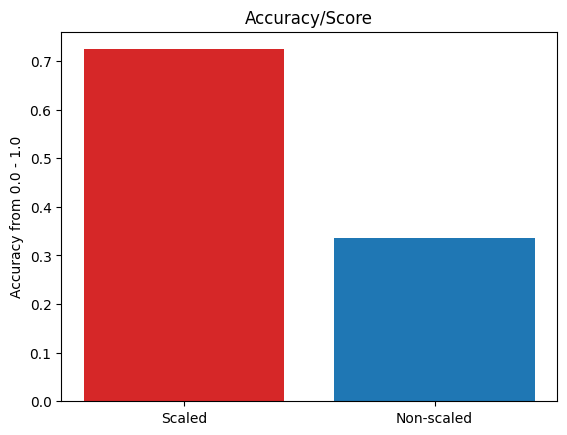

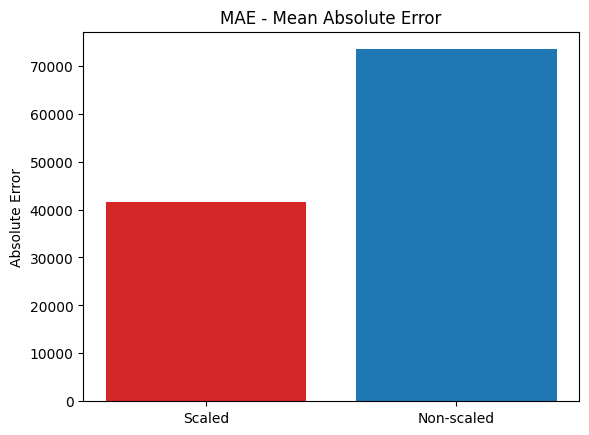

In [43]:
# Bar plot for accuracy
fig, ax = plt.subplots()

metrics = ['Scaled', 'Non-scaled']
counts = [explained_variance_scaled, explained_variance_not_scaled]
bar_colors = ['tab:red', 'tab:blue']

ax.bar(metrics, counts, color=bar_colors)

ax.set_ylabel('Accuracy from 0.0 - 1.0')
ax.set_title('Accuracy/Score')
plt.show()

# Bar plot for MAE
fig, ax = plt.subplots()

metrics = ['Scaled', 'Non-scaled']
counts = [mean_absolute_error_scaled, mean_absolute_error_not_scaled]
bar_colors = ['tab:red', 'tab:blue']

ax.bar(metrics, counts, color=bar_colors)

ax.set_ylabel('Absolute Error')
ax.set_title('MAE - Mean Absolute Error')
plt.show()

#**Discussing Results**

It seems that applying the scaler to the numerical columns makes our model **MUCH** better. Our explained_variance (which is a metric for how well our regression performed, the closer to 1 the better) went from 0.33 to 0.73 simply by applying the scaler.

Also the MAE for the scaled was 40,000 compared to the ~72,000 on the non-scaled which is much better as well.

This is most-likely due to the scaler accounting for the homes which are obscenely expensive and scaling it appropriately. Thus both our accuracy and our MAE improves by a lot.


# **Writing Assignment**


*   *Question: What is the difference between supervised and unsupervised problems?*
    *   Answer: The main difference between the two is supervised learning works with labeled datasets and takes that into account when making predictions. On the otherhand, unsupervised learning looks at clusters of unlabeled data (can sometimes find hidden patterns humans can't see).
*   *Question: What is the purpose of splitting data into training, validaiton, and testing sets? What is a typical split up?*
    *   Answer: The purpose of splitting data into training, validation and testing sets is to assess how the model performs on unseen data after training and avoid overfitting. Validation is used for tweaking hyperparameters to fine-tune the model further. A typical split is 60:20:20 for train-data:test-data:validation-data










<Axes: >

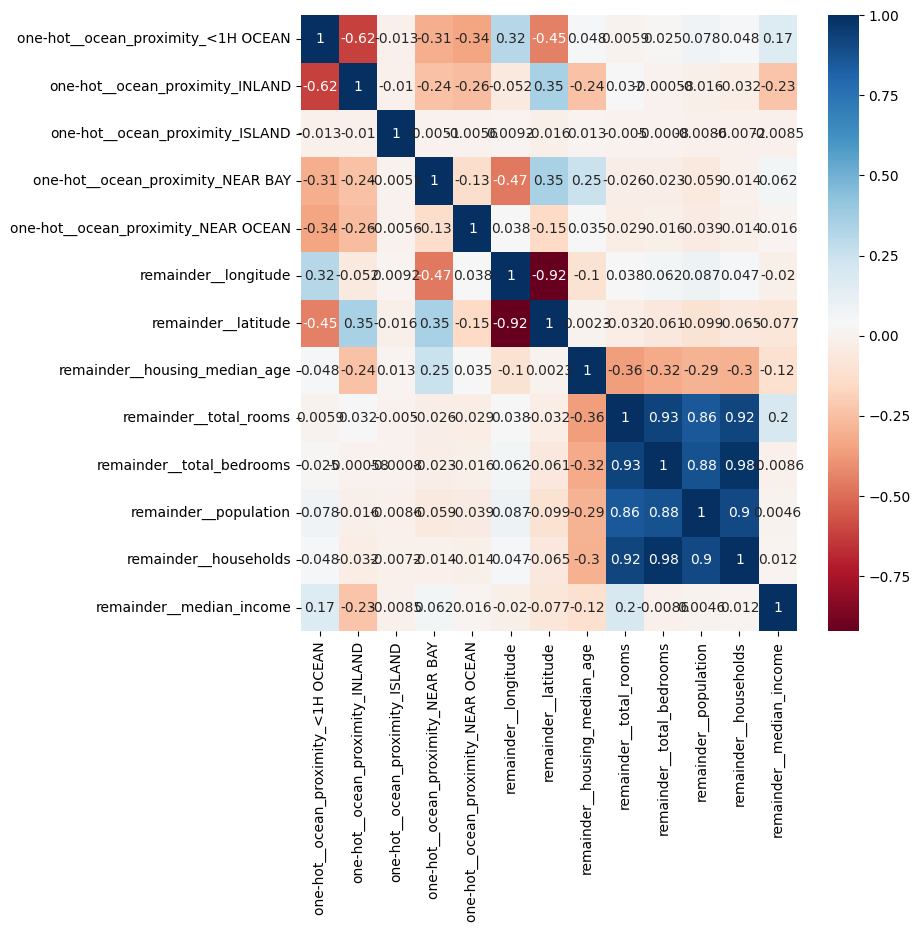

In [44]:
# Plot heat map for fun to see correlations
plt.figure(figsize=(8,8))
sns.heatmap(data_transformed.corr(), cmap="RdBu", annot=True)